In [118]:
import pandas as pd
import numpy as np
import json
import pickle

from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_pickle('interact')

Bring in a dataset for book infomation

In [3]:
df_book = pd.read_pickle('book_info')

In [5]:
df_book.sample(5)

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
83428,9737513,1Q84 #1,"[{'count': '32780', 'name': 'to-read'}, {'coun...","Podobnie jak w ""Kafce nad morzem"" autor rozwij...","[{'author_id': '3354', 'role': ''}, {'author_i...",3.97,67,https://www.goodreads.com/book/show/9737513-1q...,https://images.gr-assets.com/books/1417441303m...
233064,23472076,"Infected: Life After Death (Infected, #3)","[{'count': '472', 'name': 'to-read'}, {'count'...",In a world where a werecat virus has changed s...,"[{'author_id': '3020553', 'role': ''}]",4.22,250,https://www.goodreads.com/book/show/23472076-i...,https://images.gr-assets.com/books/1416211030m...
258169,33786532,A Human Stain,"[{'count': '155', 'name': 'to-read'}, {'count'...",A Human Stain by Kelly Robson is a disturbing ...,"[{'author_id': '13461530', 'role': ''}]",3.53,105,https://www.goodreads.com/book/show/33786532-a...,https://s.gr-assets.com/assets/nophoto/book/11...
32899,22735855,Scale-Bright,"[{'count': '547', 'name': 'to-read'}, {'count'...",Julienne's aunts are the archer who shot down ...,"[{'author_id': '6569623', 'role': ''}]",3.77,171,https://www.goodreads.com/book/show/22735855-s...,https://images.gr-assets.com/books/1405581253m...
161141,2268134,The Doomspell Trilogy,"[{'count': '181', 'name': 'to-read'}, {'count'...",,"[{'author_id': '27813', 'role': ''}]",4.09,347,https://www.goodreads.com/book/show/2268134.Th...,https://images.gr-assets.com/books/1333573039m...


In [6]:
df.sample(5)

,user_id_num,book_id,rating
2639,81,15881,5
34842,502,27712,4
48751,459,308744,5
8005,733,17245,3
9470,852,6527740,5


In [10]:
idx = list(set(df['book_id']))

In [19]:
library = df_book[df_book['book_id'].isin(idx)]
library

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
9,780918,"Rite of Conquest (William the Conqueror, #1)","[{'count': '145', 'name': 'to-read'}, {'count'...",,"[{'author_id': '41194', 'role': ''}]",3.43,148,https://www.goodreads.com/book/show/780918.Rit...,https://images.gr-assets.com/books/1309203943m...
42,18663972,"Fortune's Pawn (Paradox, #1)","[{'count': '12597', 'name': 'to-read'}, {'coun...",When professional mercenary Deviana Morris too...,"[{'author_id': '6572837', 'role': ''}]",3.96,1023,https://www.goodreads.com/book/show/18663972-f...,https://s.gr-assets.com/assets/nophoto/book/11...
44,9402756,The Shadow Queen (The Black Jewels #7),"[{'count': '3501', 'name': 'to-read'}, {'count...",The national bestselling Black Jewels saga con...,"[{'author_id': '26897', 'role': ''}]",4.29,19,https://www.goodreads.com/book/show/9402756-th...,https://images.gr-assets.com/books/1297875072m...
47,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,"[{'count': '10607', 'name': 'to-read'}, {'coun...",Peter Nimble and His Fantastic Eyesis the utte...,"[{'author_id': '4722094', 'role': ''}]",4.04,6049,https://www.goodreads.com/book/show/10806008-p...,https://images.gr-assets.com/books/1353594747m...
55,11731782,"Collide (Collide, #1)","[{'count': '6001', 'name': 'to-read'}, {'count...",Sherry has always known there was something ou...,"[{'author_id': '4951964', 'role': ''}]",3.86,5125,https://www.goodreads.com/book/show/11731782-c...,https://images.gr-assets.com/books/1352764436m...
...,...,...,...,...,...,...,...,...,...
258543,279665,"Brave the Betrayal (Everworld, #8)","[{'count': '622', 'name': 'to-read'}, {'count'...","David, Christopher, Jalil and April have a new...","[{'author_id': '1036736', 'role': ''}]",3.90,1767,https://www.goodreads.com/book/show/279665.Bra...,https://images.gr-assets.com/books/1322353274m...
258544,279666,"Entertain the End (Everworld, #12)","[{'count': '691', 'name': 'to-read'}, {'count'...",There is a place that shouldn't exist. But doe...,"[{'author_id': '1036736', 'role': ''}]",3.89,1607,https://www.goodreads.com/book/show/279666.Ent...,https://images.gr-assets.com/books/1375603617m...
258545,279667,"Mystify the Magician (Everworld, #11)","[{'count': '670', 'name': 'to-read'}, {'count'...",There is a place that shouldn't exist. But doe...,"[{'author_id': '1036736', 'role': ''}]",3.98,1586,https://www.goodreads.com/book/show/279667.Mys...,https://images.gr-assets.com/books/1375603595m...
258549,57064,"Hammerfall (The Gene Wars, #1)","[{'count': '22', 'name': 'to-read'}, {'count':...",One of the most renowned figures in science fi...,"[{'author_id': '989968', 'role': ''}]",3.62,1143,https://www.goodreads.com/book/show/57064.Hamm...,https://s.gr-assets.com/assets/nophoto/book/11...


## Create User input

In [61]:
def book_rater(library, num):
    userID = 10000
    book_list = []
    while num > 0:
        book = library.sample(1)
        print('Book Title: ', book['title'].values[0])
        print('Average Rating from Users: ', book['average_rating'].values[0])
        print('-' * 50)
        
        rating = input('Have you read the book?\n If so, how do you rate this book (on scale 1-5)?\n If not, please type \"n\"\n')
        
        if rating == 'n':
            continue
        else:
            rating_abook = {'user_id_num':userID, 'book_id':book['book_id'].values[0],'rating':int(rating)}
            if rating_abook['rating'] < 1:
                rating_abook['rating'] = 1
            if rating_abook['rating'] > 5:
                rating_abook['rating'] = 5
            book_list.append(rating_abook) 
            num -= 1
            print('-' * 50)
    return book_list

In [192]:
user_rating = book_rater(library, 8)

Book Title:  The Tale of the Body Thief (The Vampire Chronicles, #4)
Average Rating from Users:  3.71
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
2
--------------------------------------------------
Book Title:  Demon Road (Demon Road, #1)
Average Rating from Users:  4.05
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
3
--------------------------------------------------
Book Title:  Ignite Me (Shatter Me, #3)
Average Rating from Users:  4.44
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
2
--------------------------------------------------
Book Title:  Shadow and Bone & Siege and Storm (The Grisha #1-2)
Average Rating from Users:  4.32
--------------------------------------------

In [202]:
user_rating

[{'user_id_num': 10000, 'book_id': 159206, 'rating': 2},
 {'user_id_num': 10000, 'book_id': 23253921, 'rating': 3},
 {'user_id_num': 10000, 'book_id': 13188676, 'rating': 2},
 {'user_id_num': 10000, 'book_id': 18217960, 'rating': 4},
 {'user_id_num': 10000, 'book_id': 601719, 'rating': 5},
 {'user_id_num': 10000, 'book_id': 16051689, 'rating': 4},
 {'user_id_num': 10000, 'book_id': 18668746, 'rating': 3},
 {'user_id_num': 10000, 'book_id': 199781, 'rating': 5}]

## Making Prediction With the New Ratings

In [203]:
reader = Reader()

In [204]:
new_df = df.append(user_rating, ignore_index=True)
new_data = Dataset.load_from_df(new_df, reader)

In [205]:
svd_final_model = SVD(n_factors= 20, reg_all=0.02)
svd_final_model.fit(new_data.build_full_trainset())

In [206]:
list_of_books = []
for m_id in new_df['book_id'].unique():
    list_of_books.append( (m_id,svd_final_model.predict(10000,m_id)[3]))

In [207]:
list_of_books

[(29056083, 3.4682822544824385),
 (33266253, 3.738099420779637),
 (667488, 3.7301715279859207),
 (820343, 4.0433073262935855),
 (23734628, 3.7564008913766496),
 (6068551, 3.221204600285166),
 (353016, 3.6905253359705625),
 (15745371, 3.8637623125021654),
 (12603860, 3.572890431504734),
 (13076222, 3.6284053516748362),
 (12751687, 3.520076838798183),
 (10637766, 3.594127653397519),
 (7263429, 3.7075473776332295),
 (15861491, 3.6292950316313215),
 (7171637, 3.843280189231429),
 (187811, 3.7566084931270414),
 (10429045, 3.7131896831480518),
 (7124101, 3.4306139350705793),
 (8130839, 3.588346527897449),
 (10314229, 3.6200445804216006),
 (5266655, 3.408494072749407),
 (100915, 3.767201575794093),
 (6583427, 3.640815489933896),
 (6763961, 3.575609375610814),
 (7476122, 3.679470305547368),
 (11443325, 3.420665540431968),
 (8428064, 3.7844632584099345),
 (11454587, 3.5914856233904824),
 (8487363, 3.718064261405725),
 (8803932, 3.7556589187016796),
 (11418574, 3.773655313474392),
 (13508069, 3.

In [208]:
ranked_books = sorted(list_of_books, key=lambda x:x[1], reverse=True)

### Get Titles of Recommended Books Function

In [211]:
def recommended_books(user_ratings, book_title_df, n):
        rec_list = []
        for idx, rec in enumerate(user_ratings):
            title = book_title_df.loc[book_title_df['book_id'] == int(rec[0])]
            print('Recommendation #', idx+1, ': ', title['title'].values[0], '\n')
            rec_list.append(title['book_id'].values[0])
            n -= 1
            
            i = title['image_url'].values[0]
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            print(plt.imshow(img))
            
            if n == 0:
                return rec_list

Recommendation # 1 :  The Name of the Wind (The Kingkiller Chronicle, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 2 :  Harry Potter Boxset (Harry Potter, #1-7) 

AxesImage(54,36;334.8x217.44)
Recommendation # 3 :  The Wise Man's Fear (The Kingkiller Chronicle, #2) 

AxesImage(54,36;334.8x217.44)
Recommendation # 4 :  The Way of Kings (The Stormlight Archive, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 5 :  A Monster Calls 

AxesImage(54,36;334.8x217.44)
Recommendation # 6 :  A Game of Thrones (A Song of Ice and Fire, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 7 :  Words of Radiance (The Stormlight Archive, #2) 

AxesImage(54,36;334.8x217.44)
Recommendation # 8 :  I Am Legend and Other Stories 

AxesImage(54,36;334.8x217.44)
Recommendation # 9 :  Assassin's Apprentice (Farseer Trilogy, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 10 :  Six of Crows (Six of Crows, #1) 

AxesImage(54,36;334.8x217.44)


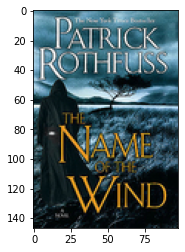

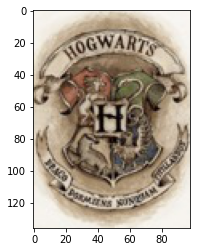

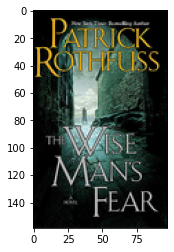

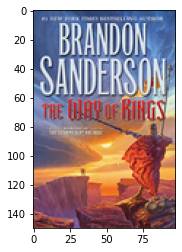

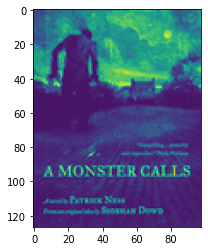

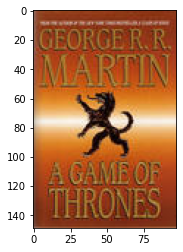

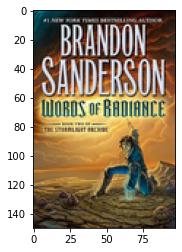

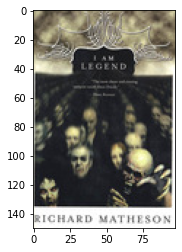

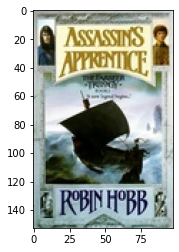

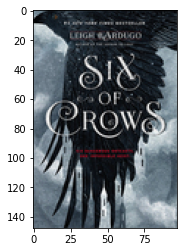

In [212]:
rec_idx = recommended_books(ranked_books, library, 10)

# Build Comics Recommendation based of Book Description

### Import necessary datasets 

In [72]:
df_comics = pd.read_json('data/goodreads_books_comics_graphic.json', lines=True)

In [73]:
df_comics.sample(5)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
64083,,20,[1016992],US,eng,"[{'count': '258', 'name': 'to-read'}, {'count'...",,false,3.92,,...,6,,2016,https://www.goodreads.com/book/show/30652560-b...,https://images.gr-assets.com/books/1466386130m...,30652560,275,51196837,Black Panther #3,Black Panther #3
77311,,7,[],US,,"[{'count': '6', 'name': 'comics'}, {'count': '...",B01M26W2SQ,true,3.76,B01M26W2SQ,...,,,,https://www.goodreads.com/book/show/33911075-m...,https://s.gr-assets.com/assets/nophoto/book/11...,33911075,35,54876601,Monsters Unleashed (2017) #1 (of 5),Monsters Unleashed (2017) #1 (of 5)
87545,,1,[537711],US,ind,"[{'count': '634', 'name': 'to-read'}, {'count'...",,false,4.06,,...,11,,2010,https://www.goodreads.com/book/show/9596306-cr...,https://s.gr-assets.com/assets/nophoto/book/11...,9596306,5,1101380,CRAYON SHINCHAN vol. 01,CRAYON SHINCHAN vol. 01
18969,4091260594,4,[798252],US,jpn,"[{'count': '34', 'name': 'to-read'}, {'count':...",,false,4.30,,...,6,,2015,https://www.goodreads.com/book/show/25916784-s...,https://images.gr-assets.com/books/1436997442m...,25916784,64,45805429,銀の匙 Silver Spoon 13 [Gin no Saji Silver Spoon 13],銀の匙 Silver Spoon 13 [Gin no Saji Silver Spoon 13]
68428,1603094067,10,[],US,,"[{'count': '24', 'name': 'to-read'}, {'count':...",,false,3.60,,...,2,,2017,https://www.goodreads.com/book/show/31389667-y...,https://images.gr-assets.com/books/1478184139m...,31389667,42,52079234,You Might Be an Artist If...,You Might Be an Artist If...


In [74]:
df_comics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89411 entries, 0 to 89410
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  89411 non-null  object 
 1   text_reviews_count    89411 non-null  int64  
 2   series                89411 non-null  object 
 3   country_code          89411 non-null  object 
 4   language_code         89411 non-null  object 
 5   popular_shelves       89411 non-null  object 
 6   asin                  89411 non-null  object 
 7   is_ebook              89411 non-null  object 
 8   average_rating        89411 non-null  float64
 9   kindle_asin           89411 non-null  object 
 10  similar_books         89411 non-null  object 
 11  description           89411 non-null  object 
 12  format                89411 non-null  object 
 13  link                  89411 non-null  object 
 14  authors               89411 non-null  object 
 15  publisher          

**Use only english language comics**

In [106]:
df_comics.description.sample(1)

9463    At age 31, office worker Chikage Deguchi feels...
Name: description, dtype: object

In [86]:
df_comics = df_comics[df_comics.language_code == 'eng']

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
2,,5,"[246830, 362583, 362581, 623032]",US,eng,"[{'count': '493', 'name': 'to-read'}, {'count'...",,false,4.28,,...,,,2012,https://www.goodreads.com/book/show/13571772-c...,https://images.gr-assets.com/books/1333287305m...,13571772,51,102217,Captain America: Winter Soldier (The Ultimate ...,Captain America: Winter Soldier (The Ultimate ...
3,,1,[],US,eng,"[{'count': '222', 'name': 'to-read'}, {'count'...",B06XKGGSB7,true,4.05,B06XKGGSB7,...,,,,https://www.goodreads.com/book/show/35452242-b...,https://s.gr-assets.com/assets/nophoto/book/11...,35452242,6,54276229,Bounty Hunter 4/3: My Life in Combat from Mari...,Bounty Hunter 4/3: My Life in Combat from Mari...
6,1592912729,9,[834955],US,eng,"[{'count': '47', 'name': 'to-read'}, {'count':...",,false,4.15,,...,1,,2016,https://www.goodreads.com/book/show/27036536-w...,https://images.gr-assets.com/books/1445402463m...,27036536,39,47077783,"War Stories, Volume 3","War Stories, Volume 3"
11,1606902172,26,[774390],US,eng,"[{'count': '104', 'name': 'to-read'}, {'count'...",,false,3.16,B01D5JQT5C,...,11,,2011,https://www.goodreads.com/book/show/11827783-s...,https://s.gr-assets.com/assets/nophoto/book/11...,11827783,114,16782451,Sherlock Holmes: Year One,Sherlock Holmes: Year One
12,1421535386,6,[231780],US,eng,"[{'count': '133', 'name': 'manga'}, {'count': ...",,false,4.41,,...,4,,2012,https://www.goodreads.com/book/show/12349665-n...,https://images.gr-assets.com/books/1344390009m...,12349665,149,3062163,"Naoki Urasawa's 20th Century Boys, Volume 20 (...","Naoki Urasawa's 20th Century Boys, Volume 20 (..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89401,1421526123,4,[249580],US,eng,"[{'count': '54', 'name': 'manga'}, {'count': '...",,false,4.09,B00FDZIZBS,...,11,,2009,https://www.goodreads.com/book/show/6419558-ke...,https://s.gr-assets.com/assets/nophoto/book/11...,6419558,172,6608706,"Kekkaishi, Vol. 19 (Kekkaishi, #19)","Kekkaishi, Vol. 19 (Kekkaishi, #19)"
89402,,3,[],US,eng,"[{'count': '9', 'name': 'to-read'}, {'count': ...",,false,4.73,,...,10,,2016,https://www.goodreads.com/book/show/32598998-t...,https://images.gr-assets.com/books/1476308653m...,32598998,3,53177155,The Black Monday Murders #3,The Black Monday Murders #3
89404,1592911196,53,[],US,eng,"[{'count': '625', 'name': 'to-read'}, {'count'...",,false,3.74,B000FC29J8,...,8,,2011,https://www.goodreads.com/book/show/10644600-f...,https://images.gr-assets.com/books/1350850473m...,10644600,853,18566693,Fevre Dream,Fevre Dream
89409,,2,[],US,eng,"[{'count': '1', 'name': '3-2017-ha-pages-read-...",,true,3.00,,...,2,,2016,https://www.goodreads.com/book/show/28928706-d...,https://images.gr-assets.com/books/1454539757m...,28928706,10,49145631,Dejah Thoris #1,Dejah Thoris #1


### create a dataframe from recommended book index

In [213]:
rec_book_df = library[library['book_id'].isin(rec_idx)]
rec_book_df 

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
660,186074,The Name of the Wind (The Kingkiller Chronicle...,"[{'count': '296158', 'name': 'to-read'}, {'cou...","Told in Kvothe's own voice, this is the tale o...","[{'author_id': '108424', 'role': ''}]",4.55,416634,https://www.goodreads.com/book/show/186074.The...,https://images.gr-assets.com/books/1472068073m...
16001,8621462,A Monster Calls,"[{'count': '5576', 'name': 'favorites'}, {'cou...","An unflinching, darkly funny, and deeply movin...","[{'author_id': '370361', 'role': ''}, {'author...",4.37,110050,https://www.goodreads.com/book/show/8621462-a-...,https://images.gr-assets.com/books/1485991317m...
41331,7235533,"The Way of Kings (The Stormlight Archive, #1)","[{'count': '122397', 'name': 'to-read'}, {'cou...","Speak again the ancient oaths,\nLife before de...","[{'author_id': '38550', 'role': ''}]",4.64,151473,https://www.goodreads.com/book/show/7235533-th...,https://images.gr-assets.com/books/1507307887m...
42064,17332218,"Words of Radiance (The Stormlight Archive, #2)","[{'count': '34035', 'name': 'to-read'}, {'coun...",From #1 New York Times bestselling author Bran...,"[{'author_id': '38550', 'role': ''}]",4.77,78319,https://www.goodreads.com/book/show/17332218-w...,https://images.gr-assets.com/books/1507307927m...
73267,862041,"Harry Potter Boxset (Harry Potter, #1-7)","[{'count': '5605', 'name': 'favorites'}, {'cou...","The exciting tales of Harry Potter, the young ...","[{'author_id': '1077326', 'role': ''}]",4.74,193057,https://www.goodreads.com/book/show/862041.Har...,https://images.gr-assets.com/books/1392579059m...
75367,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...","[{'count': '80702', 'name': 'to-read'}, {'coun...","""There are three things all wise men fear: the...","[{'author_id': '108424', 'role': ''}]",4.57,253462,https://www.goodreads.com/book/show/1215032.Th...,https://images.gr-assets.com/books/1452624392m...
162976,547094,I Am Legend and Other Stories,"[{'count': '77169', 'name': 'to-read'}, {'coun...",Robert Neville is the last living man on Earth...,"[{'author_id': '8726', 'role': ''}]",3.99,100249,https://www.goodreads.com/book/show/547094.I_A...,https://images.gr-assets.com/books/1317791583m...
177770,23437156,"Six of Crows (Six of Crows, #1)","[{'count': '213045', 'name': 'to-read'}, {'cou...",Criminal prodigy Kaz Brekker has been offered ...,"[{'author_id': '4575289', 'role': ''}]",4.46,102183,https://www.goodreads.com/book/show/23437156-s...,https://images.gr-assets.com/books/1500689111m...
191446,13496,"A Game of Thrones (A Song of Ice and Fire, #1)","[{'count': '2242', 'name': 'to-read'}, {'count...",Summers span decades. Winter can last a lifeti...,"[{'author_id': '346732', 'role': ''}]",4.45,1359501,https://www.goodreads.com/book/show/13496.A_Ga...,https://images.gr-assets.com/books/1436732693m...
194958,45107,"Assassin's Apprentice (Farseer Trilogy, #1)","[{'count': '1934', 'name': 'to-read'}, {'count...",In a faraway land where members of the royal f...,"[{'author_id': '25307', 'role': ''}]",4.14,133239,https://www.goodreads.com/book/show/45107.Assa...,https://images.gr-assets.com/books/1320339497m...


## Text Preprocession 

In [214]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
# Function for converting into lower case
def make_lower_case(text):
    return text.lower()
# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
#Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

### Cleaning book and comics description 

In [215]:
rec_book_df['cleaned_des'] = rec_book_df['description'].apply(_removeNonAscii)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = make_lower_case)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_stop_words)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_punctuation) 
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_html)

<ipython-input-215-75105bb5f139>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_book_df['cleaned_des'] = rec_book_df['description'].apply(_removeNonAscii)
<ipython-input-215-75105bb5f139>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = make_lower_case)
<ipython-input-215-75105bb5f139>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [112]:
df_comics['cleaned_des'] = df_comics['description'].apply(_removeNonAscii)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = make_lower_case)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_stop_words)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_punctuation) 
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_html)

In [113]:
filename = 'comics_cleaned_description'
outfile = open(filename,'wb')
pickle.dump(df_comics,outfile)
outfile.close()

### Converting the book description into vectors using minigram or bigram

In [216]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df = 1, stop_words='english')

In [217]:
tfidf_matrix = tf.fit_transform(rec_book_df['cleaned_des'])

In [218]:
comics_matrix = tf.transform(df_comics['cleaned_des'])

### Calculating the similarity measures based on Cosine Similarity

In [219]:
cos_sim = cosine_similarity(comics_matrix, tfidf_matrix)

In [220]:
cos_sim_df = pd.DataFrame(cos_sim, index=df_comics['book_id'] , columns=rec_book_df['book_id'])

In [221]:
cos_sim_df

book_id,186074,8621462,7235533,17332218,862041,1215032,547094,23437156,13496,45107
book_id,,,,,,,,,,
25742454,0.043024,0.052709,0.052932,0.061459,0.024001,0.065865,0.061499,0.029367,0.000000,0.073311
30128855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089138
13571772,0.000000,0.019870,0.013425,0.076823,0.007428,0.034417,0.000000,0.047848,0.024220,0.075095
35452242,0.038358,0.030351,0.096906,0.101009,0.010990,0.055975,0.048720,0.040655,0.041159,0.053035
707611,0.020147,0.000000,0.014238,0.116375,0.023632,0.000000,0.021164,0.022187,0.000000,0.019039
...,...,...,...,...,...,...,...,...,...,...
30848889,0.022309,0.000000,0.000000,0.073673,0.036210,0.024591,0.023435,0.000000,0.031112,0.042164
33553114,0.117259,0.015652,0.010575,0.009179,0.040145,0.076072,0.061935,0.000000,0.030162,0.014141
20653416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [222]:
cos_sim_df.describe()

book_id,186074,8621462,7235533,17332218,862041,1215032,547094,23437156,13496,45107
count,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000,89411.000000
mean,0.024268,0.017935,0.014817,0.025376,0.012689,0.027729,0.021276,0.011275,0.012663,0.022681
std,0.034216,0.030491,0.026566,0.032405,0.021872,0.035558,0.035958,0.021726,0.024818,0.030213
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.008546,0.000000,0.014575,0.000000,0.000000,0.000000,0.000000
75%,0.042903,0.027762,0.021378,0.045730,0.021027,0.047045,0.033504,0.014095,0.019090,0.041002
max,0.241626,0.249550,0.230997,0.222194,0.830411,0.275077,0.771306,0.225452,0.361576,0.303101


In [223]:
cos_sim_df[186074].idxmax()

29499014

In [224]:
rec_comic_idx = [cos_sim_df[x].idxmax() for x in cos_sim_df.columns]

In [225]:
rec_comic_idx

[29499014,
 32693872,
 30842280,
 29963977,
 29637277,
 33782213,
 12191933,
 106983,
 22889758,
 36356923]

## Get Recommended Comics Titles 

In [226]:
def recommended_comics(arr, comics_df):
        for idx, rec in enumerate(arr):
            title = comics_df.loc[comics_df['book_id'] == int(rec)]
            print('Recommendation #', idx+1, ': ', title['title'].values[0], '\n')
            
            i = title['image_url'].values[0]
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            print(plt.imshow(img))


Recommendation # 1 :  Goodnight Punpun Omnibus (2-in-1 Edition), Vol. 4 (Goodnight Punpun Omnibus, #4) 

AxesImage(54,36;334.8x217.44)
Recommendation # 2 :  monster elementary the egyptian curse 

AxesImage(54,36;334.8x217.44)
Recommendation # 3 :  Star Wars Legends Epic Collection: The Old Republic, Vol. 2 

AxesImage(54,36;334.8x217.44)
Recommendation # 4 :  White Sand (White Sand, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 5 :  Ye 

AxesImage(54,36;334.8x217.44)
Recommendation # 6 :  Daredevil: The Man Without Fear (1993-1994) #5 (of 5) 

AxesImage(54,36;334.8x217.44)
Recommendation # 7 :  I Am Legend 

AxesImage(54,36;334.8x217.44)
Recommendation # 8 :  The Punisher MAX, Vol. 3: Mother Russia 

AxesImage(54,36;334.8x217.44)
Recommendation # 9 :  A Game of Thrones: The Graphic Novel, Vol. 4 

AxesImage(54,36;334.8x217.44)
Recommendation # 10 :  Grandes Autores de la Liga de la Justicia: Keith Giffen, J.M. DeMatteis y Kevin Maguire. JLI 

AxesImage(54,36;334.8x217.44)


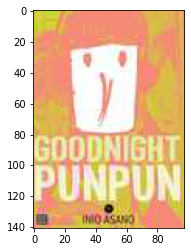

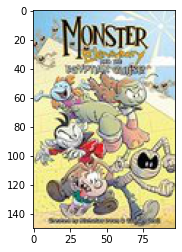

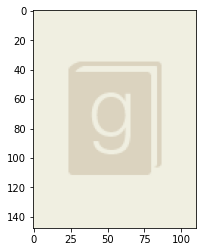

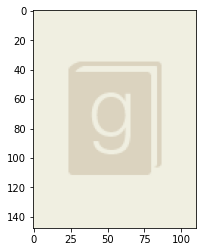

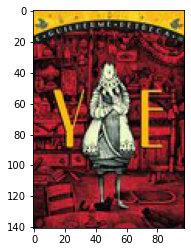

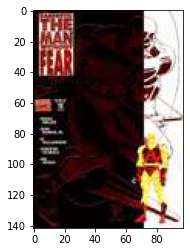

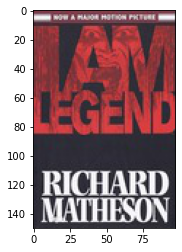

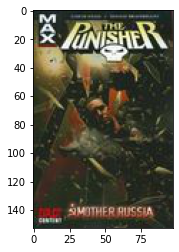

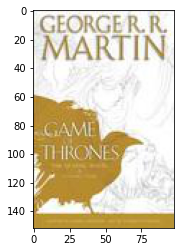

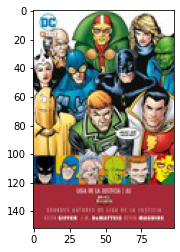

In [227]:
recommended_comics(rec_comic_idx, df_comics)